In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from datetime import datetime
import joblib
# Ler o arquivo CSV com tabulação como delimitador
data = pd.read_csv('WDO_candles_07.csv')

# Exibir as primeiras linhas do DataFrame para garantir que o arquivo foi lido corretamente
data


,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-07-01 16:55:00,5720.0,5720.0,5720.0,5720.0,1,500,1
1,2024-07-02 11:13:00,5732.5,5732.5,5732.5,5732.5,1,500,1
2,2024-07-02 11:33:00,5722.0,5722.0,5722.0,5722.0,1,500,2
3,2024-07-03 10:37:00,5672.0,5672.0,5672.0,5672.0,1,500,2
4,2024-07-03 10:39:00,5657.0,5657.0,5657.0,5657.0,1,500,1
...,...,...,...,...,...,...,...,...
15344,2024-10-17 10:58:00,5678.5,5681.0,5678.5,5680.5,658,0,5367
15345,2024-10-17 10:59:00,5680.0,5681.0,5679.5,5680.0,539,0,5290
15346,2024-10-17 11:00:00,5680.0,5684.5,5680.0,5684.0,1289,0,11725
15347,2024-10-17 11:01:00,5684.5,5686.5,5684.0,5685.0,1086,0,9927


In [4]:
# Adicionando indicadores técnicos ao DataFrame
# RSI (Relative Strength Index) com uma janela de 15 períodos
data['RSI'] = ta.rsi(data.close, length=5)

# EMA (Exponential Moving Average) com diferentes janelas de tempo: 20, 100 e 150
data['EMAF'] = ta.ema(data.close, length=10)
data['EMAM'] = ta.ema(data.close, length=40)
data['EMAS'] = ta.ema(data.close, length=80)

# Criando a coluna 'Target' que é a diferença entre o preço de fechamento e abertura
data['Target'] = data['close'] - data.open

# Deslocando a coluna 'Target' para calcular o valor alvo do próximo candle
data['Target'] = data['Target'].shift(-1)

# Criando uma coluna 'TargetClass', onde 1 indica que o próximo candle foi de alta (target > 0) e 0 para queda
data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

# Coluna 'TargetNextClose' contém o valor de fechamento do próximo candle
data['TargetNextClose'] = data['close'].shift(-1)

# Removendo valores nulos que podem ter sido introduzidos pelas operações de deslocamento (shift)
data.dropna(inplace=True)

# Resetando o índice após a remoção de linhas
data.reset_index(drop=True, inplace=True)
print(data.columns)

# Removendo colunas desnecessárias que não serão usadas no modelo
data.drop(['time', 'spread', 'tick_volume', 'real_volume'], axis=1, inplace=True)

# Selecionando as primeiras 11 colunas do DataFrame para o conjunto de dados final
data_set = data.iloc[:, 0:11]  # .values apenas para pegar as colunas
pd.set_option('display.max_columns', None)

# Exibindo as primeiras 20 linhas do data_set para verificar a seleção
data_set.head(20)

# Criando a lista 'y' que contém 1 se a abertura for maior que o target, e 0 caso contrário
#y = [1 if data.open[i] > data.Target[i] else 0 for i in range(0, len(data))]

# Criando a lista 'yi' que contém a diferença entre o valor de abertura e o target
#yi = [data.open[i] - data.Target[i] for i in range(0, len(data))]

# Exibindo as primeiras 10 entradas das listas 'y' e 'yi' para verificação
#print("Primeiras 10 entradas de y:", y[:10])
#print("Primeiras 10 entradas de yi:", yi[:10])

# Normalizando os dados entre 0 e 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Aplicando a normalização aos dados selecionados
data_set_scaled = sc.fit_transform(data_set)
joblib.dump(sc, 'scaler_target_WDO_past01.pkl')
print(data_set_scaled)

# Criação de múltiplas features (variáveis) a serem fornecidas ao modelo
X = []
#print(data_set_scaled[0])

# Converter data_set_scaled de volta para valores do DataFrame
#data_set_scaled = data_set.values

# Definindo o número de candles anteriores a serem considerados como features (backcandles)
backcandles = 5
print(data_set_scaled[0].size)

# Criando as features X para cada coluna
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])
        
# Convertendo X para um array NumPy e reorganizando para o formato correto
X=np.moveaxis(X, [0], [2])

# Removendo os primeiros elementos de 'yi' para ajustar o tamanho após considerar os 'backcandles'
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

# Verificando a forma de X e y
print(X)
print(X.shape)
print(y)
print(y.shape)

# Criando features X novamente para as primeiras 8 colunas
#X = np.array([data_set_scaled[i-backcandles:i, :8].copy() for i in range(backcandles, len(data_set_scaled))])

# Dividindo os dados em conjuntos de treino e teste (80% para treino, 20% para teste)
splitlimit = int(len(X) * 0.8)
print(splitlimit)

# Definindo os dados de treino e teste para X e y
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass',
       'TargetNextClose'],
      dtype='object')
[[0.90572391 0.91       0.90619765 ... 0.57272727 0.         0.81683168]
 [0.83164983 0.815      0.83249581 ... 0.57272727 0.         0.84653465]
 [0.86195286 0.845      0.86264657 ... 0.57272727 0.         0.78382838]
 ...
 [0.86531987 0.85166667 0.86432161 ... 0.64545455 1.         0.8630363 ]
 [0.86531987 0.86333333 0.86599665 ... 0.58181818 1.         0.86633663]
 [0.88047138 0.87       0.87939698 ... 0.56363636 0.         0.8630363 ]]
11
[[[0.90572391 0.91       0.90619765 ... 1.         1.         0.83757288]
  [0.83164983 0.815      0.83249581 ... 0.9581517  0.99199987 0.83938497]
  [0.86195286 0.845      0.86264657 ... 0.92917612 0.98596308 0.84203596]
  [0.7979798  0.78166667 0.79899497 ... 0.89435608 0.9768998  0.84275602]
  [0.76430976 0.74833333 0.76549414 ... 0.86001814 0.96653

In [35]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(50, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=345, epochs=15, shuffle=True, validation_split = 0.1)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0507 - val_loss: 0.0027
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 1.6999e-04
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6668e-04 - val_loss: 6.9705e-05
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9717e-04 - val_loss: 7.2090e-05
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6234e-04 - val_loss: 8.1046e-05
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3441e-04 - val_loss: 8.9350e-05
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2730e-04 - val_loss: 9.7665e-05
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9006e-04 - val_loss: 1.0076e-04
Epoch 9/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8166e-04 - val_loss: 1.0258e-04
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7326e-04 - val_loss: 1.0007e-04
Epoch 11/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8851e-04 - val_loss: 9.9417e

In [37]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[0.60177034] [0.59570957]
[0.60900795] [0.59405941]
[0.6091278] [0.59735974]
[0.60553634] [0.59735974]
[0.6078869] [0.59570957]
[0.6093899] [0.59240924]
[0.6054107] [0.58745875]
[0.59735423] [0.58910891]
[0.58806795] [0.58910891]
[0.5845875] [0.58910891]


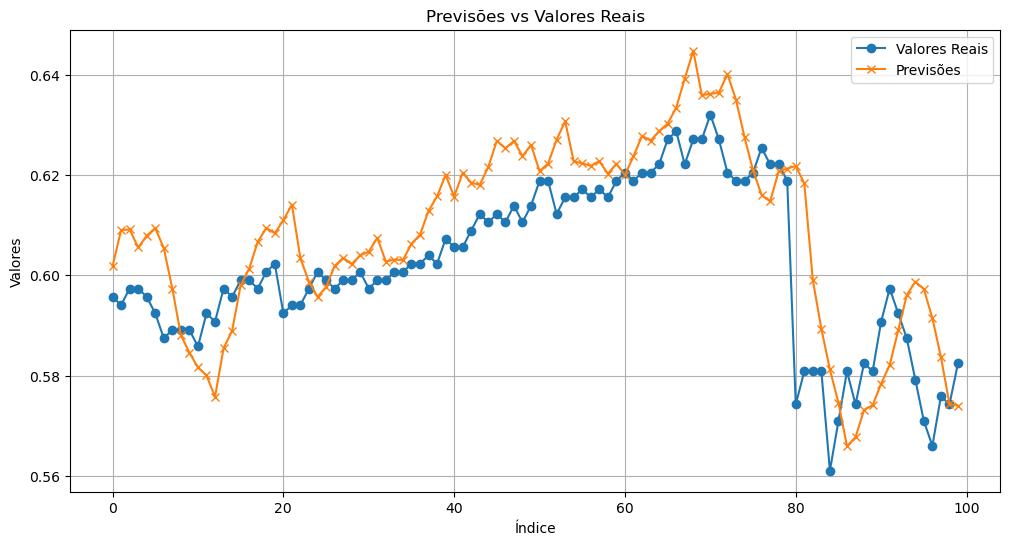

In [39]:
# Plotando previsões vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Valores Reais', marker='o')
plt.plot(y_pred[:100], label='Previsões', marker='x')
plt.title('Previsões vs Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.legend()
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Erro Absoluto Médio: {mae}')


Erro Absoluto Médio: 0.009233343143608302


In [43]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'Erro Quadrático Médio: {mse}')
print(f'Raiz do Erro Quadrático Médio: {rmse}')


Erro Quadrático Médio: 0.0001435607379519327
Raiz do Erro Quadrático Médio: 0.011981683435641785


In [21]:
!pip install joblib
import joblib
ref_cols = X
target = y

joblib.dump(value=[model, ref_cols, target], filename="modelWDO2024_past01.pkl")

['modelWDO2024_past01.pkl']

In [109]:
# save your ML model to disk
filename = 'modelWDO2024.sav'
joblib.dump(model, filename)

#load the model from disk

['mymodel1noparameters.sav']